# X-IIoTID: intrusion dataset for IoT and IIoT

[Kaggle Reference](https://www.kaggle.com/datasets/munaalhawawreh/xiiotid-iiot-intrusion-dataset)

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

## Load Dataset

In [2]:
dataset_path = kagglehub.dataset_download("munaalhawawreh/xiiotid-iiot-intrusion-dataset")
dataset_path

'C:\\Users\\Sesugh\\.cache\\kagglehub\\datasets\\munaalhawawreh\\xiiotid-iiot-intrusion-dataset\\versions\\1'

In [3]:
df_main = pl.read_csv(f"{dataset_path}/X-IIoTID dataset.csv", infer_schema_length=100_000)
df_main.head()

Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,Des_bytes,Conn_state,missed_bytes,is_syn_only,Is_SYN_ACK,is_pure_ack,is_with_payload,FIN or RST,Bad_checksum,is_SYN_with_RST,Scr_pkts,Scr_ip_bytes,Des_pkts,Des_ip_bytes,anomaly_alert,total_bytes,total_packet,paket_rate,byte_rate,Scr_packts_ratio,Des_pkts_ratio,Scr_bytes_ratio,Des_bytes_ratio,Avg_user_time,Std_user_time,Avg_nice_time,Std_nice_time,Avg_system_time,Std_system_time,Avg_iowait_time,Std_iowait_time,Avg_ideal_time,Std_ideal_time,Avg_tps,Std_tps,Avg_rtps,Std_rtps,Avg_wtps,Std_wtps,Avg_ldavg_1,Std_ldavg_1,Avg_kbmemused,Std_kbmemused,Avg_num_Proc/s,Std_num_proc/s,Avg_num_cswch/s,std_num_cswch/s,OSSEC_alert,OSSEC_alert_level,Login_attempt,Succesful_login,File_activity,Process_activity,read_write_physical.process,is_privileged,class1,class2,class3
str,str,str,str,str,str,str,str,str,str,str,i64,str,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str
"""9/01/2020""","""1578540956""","""192.168.2.199""","""49278""","""192.168.2.10""","""80""","""tcp""","""http""","""0.67369""","""13437""","""34924""",1,"""0""",true,true,true,true,true,false,false,"""105""","""18905""","""105""","""40392""","""TRUE""","""107658""","""210""","""311.7160712""","""159803.4704""","""0.5""","""0.5""","""0.300414275""","""0.699585725""","""9.207""","""5.55584206""","""10.994""","""1.356305275""","""4.864""","""1.873004004""","""0.311""","""0.224653066""","""74.624""","""8.245611196""","""12.297""","""10.38585004""","""8""","""10.50714043""","""4.297""","""2.723578712""","""2.146""","""0.102781321""","""915852.8""","""2507.97563""","""5.1""","""3.238826948""","""2806.2""","""158.7493622""",1,5,0,0,0,0,0,0,"""Scanning_vulnerability""","""Reconnaissance""","""Attack"""
"""13/01/2020""","""1578871873""","""10.0.1.5""","""39769""","""131.236.3.92""","""53""","""udp""","""dns""","""0.000083""","""78""","""0""",1,"""0""",false,false,false,true,false,false,false,"""2""","""134""","""0""","""0""","""FALSE""","""212""","""2""","""24096.38554""","""2554216.867""","""1""","""0""","""1""","""0""","""12.326""","""6.674247823""","""2.895""","""1.604302029""","""3.778""","""2.099741889""","""2.741""","""5.327471164""","""78.263""","""8.869399134""","""6.6""","""5.713142743""","""0""","""0""","""6.6""","""5.713142743""","""0.612""","""0.037629775""","""910498.4""","""4044.112046""","""1""","""0.894427191""","""1561.6""","""247.0802299""",0,0,0,0,0,0,0,0,"""Normal""","""Normal""","""Normal"""
"""9/01/2020""","""1578522486""","""172.24.1.80""","""59050""","""172.24.1.1""","""53""","""udp""","""dns""","""0.000132""","""38""","""38""",1,"""0""",false,false,false,true,false,false,false,"""1""","""66""","""1""","""66""","""FALSE""","""208""","""2""","""15151.51515""","""1575757.576""","""0.5""","""0.5""","""0.5""","""0.5""","""6.931""","""6.416007248""","""0.706""","""0.408905857""","""1.693""","""0.771635277""","""2.423""","""3.829809525""","""88.245""","""7.112108337""","""37.4""","""40.19004852""","""30.1""","""39.79811553""","""7.3""","""3.1""","""0.55""","""0.02""","""921020.4""","""2139.652645""","""1""","""0""","""1603.3""","""294.1390997""",0,0,0,0,0,0,0,0,"""Normal""","""Normal""","""Normal"""
"""27/02/2020""","""1582757640""","""192.168.2.196""","""37966""","""192.168.2.10""","""1880""","""tcp""","""websocket""","""9.378481""","""1121""","""484""",1,"""0""",true,true,true,true,true,false,false,"""8""","""1545""","""6""","""804""","""FALSE""","""3954""","""14""","""1.492779055""","""421.6034558""","""0.571428571""","""0.428571429""","""0.67425392""","""0.32574608""","""10.244""","""7.932040343""","""1.965""","""1.514168088""","""3.941""","""1.709055002""","""0.509""","""0.425522032""","""83.339""","""10.20608686""","""29""","""26.57442379""","""23.3""","""26.12680616""","""5.7""","""6.229767251""","""0.708""

## Data Analysis & Cleaning

Here, we wanna see for every column, what the data looks like? What is the data type? (float?, string?) Are any columns redundant? Meaning they have the same data for all rows? How many unique items do we have for each column?

In [4]:
def summarize_columns(df: pl.DataFrame, features: list | None = None) -> pl.DataFrame:
    """
    For a given Polars DataFrame, analyzes variable types, missing values, and distribution.

    Parameters:
    ----------
    df: pl.DataFrame
    features: list of column names to analyze. If empty, all columns will be considered.

    Returns:
    -------
    pl.DataFrame with structure analysis and recommendations for each feature.
    """

    # Use all columns if features not specified
    features = features or df.columns

    # Helper function to get value densities
    def value_densities(dataframe: pl.DataFrame, col):
        vc = dataframe[col].value_counts(sort=True)
        vc = vc.with_columns((pl.col("count") / pl.col("count").sum()).alias("density"))
        vc = vc.with_columns((pl.col("density") * 100).round(3).alias("density"))
        return vc["density"].to_list()

    # Collect column-wise stats
    result_data = []

    for col in features:
        series = df[col]
        dtype = series.dtype

        total = df.height
        missing = df.select(pl.col(col).is_null().sum())[0, 0]
        observed = total - missing
        missing_rate = round((missing / total) * 100, 2) if total > 0 else 0.0

        nunique = df.select(pl.col(col).n_unique())[0, 0]

        # Distribution densities
        densities = value_densities(df, col)
        first_density = densities[0]
        second_density = densities[1] if len(densities) > 1 else 0.0
        diff_density = round(first_density - second_density, 3)

        # Determine feature type
        if nunique <= 1:
            feature_type = "Superfluous"
        elif nunique == 2:
            feature_type = "Flag"
        elif 2 < nunique <= 10:
            feature_type = "Categorical"
        else:
            feature_type = "Categorical - High Cardinality"

        result_data.append(
            {
                "Feature": col,
                "Observations": observed,
                "Missing": missing,
                "Missing rate (%)": missing_rate,
                "1st value density (%)": first_density,
                "1st to 2nd value density difference (%)": diff_density,
                "Variable type": str(dtype),
                "Unique values": nunique,
                "Feature type": feature_type,
            }
        )

    # Create Polars DataFrame and sort it
    result_df = pl.DataFrame(result_data)
    result_df = result_df.sort(["Feature type", "Unique values"])

    return result_df


def plot_target_relationship(
    df: pl.DataFrame, feature_col: str, target_col: str = "Attack_label", log_scale: bool = False
):
    """
    Plot the relationship between a feature column and the target column using Polars for processing.

    Parameters:
        df (pl.DataFrame): The Polars DataFrame
        feature_col (str): Feature column name
        target_col (str): Target column name (categorical)
    """
    # Determine column type
    is_categorical = (
        df[feature_col].dtype in [pl.Utf8, pl.Categorical] or df[feature_col].n_unique() < 20
    )

    if is_categorical:
        # Group by feature and target to count occurrences
        grouped = df.group_by([feature_col, target_col]).len().rename({"len": "count"}).to_pandas()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=grouped, x=feature_col, y="count", hue=target_col)
        if log_scale:
            plt.yscale("log")
        plt.title(f"Distribution of {feature_col} by {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()

    else:
        # Convert needed columns to pandas for seaborn boxplot
        plot_df = df.select([feature_col, target_col]).to_pandas()

        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(data=plot_df, x=target_col, y=feature_col)
        if log_scale:
            ax.set_yscale("log")
        plt.title(f"{feature_col} distribution by {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

In [5]:
columns_df = summarize_columns(df_main)
columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""anomaly_alert""",820834,0,0.0,90.183,80.384,"""String""",3,"""Categorical"""
"""Protocol""",820834,0,0.0,51.452,3.255,"""String""",4,"""Categorical"""
"""OSSEC_alert_level""",820834,0,0.0,94.881,90.205,"""Int64""",6,"""Categorical"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""is_privileged""",820834,0,0.0,91.754,83.508,"""Int64""",2,"""Flag"""
"""FIN or RST""",820834,0,0.0,50.617,1.234,"""Boolean""",2,"""Flag"""
"""class3""",820834,0,0.0,51.34,2.68,"""String""",2,"""Flag"""


### Remove Superfluous Columns

In [6]:
superfluous_columns_df = columns_df.filter(pl.col("Feature type") == "Superfluous")
print("Number of Superfluous columns:", len(superfluous_columns_df))
superfluous_columns_df["Feature"]

Number of Superfluous columns: 2


Feature
str
"""is_SYN_with_RST"""
"""Bad_checksum"""


In [7]:
superfluous_columns_df["Feature"].to_list()

['is_SYN_with_RST', 'Bad_checksum']

In [8]:
df_main = df_main.select(pl.exclude(superfluous_columns_df["Feature"].to_list()))
columns_df = columns_df.filter(
    ~pl.col("Feature").is_in(superfluous_columns_df["Feature"].to_list())
)
print("Number of columns:", len(df_main.columns), len(columns_df))

Number of columns: 66 66


### Label Distribution

In [9]:
df_main["anomaly_alert"].value_counts()

anomaly_alert,count
str,u32
"""TRUE""",80430
"""FALSE""",740250
"""-""",154


In [10]:
[col for col in df_main.columns if col.startswith("class")]

['class1', 'class2', 'class3']

In [11]:
for i in range(3):
    display(df_main[f"class{i + 1}"].value_counts())

class1,count
str,u32
"""BruteForce""",47241
"""insider_malcious""",17447
"""MQTT_cloud_broker_subscription""",23524
"""Normal""",421417
"""Scanning_vulnerability""",52852
…,…
"""RDOS""",141261
"""MitM""",117
"""Modbus_register_reading""",5953


class2,count
str,u32
"""crypto-ransomware""",458
"""Exploitation""",1133
"""Weaponization""",67260
"""Reconnaissance""",127590
"""Lateral _movement""",31596
"""Tampering""",5122
"""RDOS""",141261
"""Normal""",421417
"""C&C""",2863


class3,count
str,u32
"""Normal""",421417
"""Attack""",399417


In [12]:
attack_label = {"Normal": 0, "Attack": 1}
df_main = df_main.with_columns(
    pl.col("class3").replace_strict(attack_label, return_dtype=pl.Int64).alias("Attack_label")
)

In [13]:
normal_df = df_main.filter(pl.col("Attack_label") == 0)
anomaly_df = df_main.filter(pl.col("Attack_label") == 1)
print(
    f"Normal: {len(normal_df)} ({len(normal_df) * 100/len(df_main):.2f}%) vs. Anomaly: {len(anomaly_df)} ({len(anomaly_df) * 100/len(df_main):.2f}%)"
)

Normal: 421417 (51.34%) vs. Anomaly: 399417 (48.66%)


### Convert or Drop String Columns

Here, we'd convert columns of string type that can be numerical or we drop string columns that are _unnecessary_ (we cannot really use).

In [14]:
string_columns_df = columns_df.filter(pl.col("Variable type") == "String").sort(
    by="Unique values", descending=True
)
string_columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""byte_rate""",820834,0,0.0,27.274,26.936,"""String""",339658,"""Categorical - High Cardinality"""
"""Duration""",820834,0,0.0,9.23,8.249,"""String""",330207,"""Categorical - High Cardinality"""
"""paket_rate""",820834,0,0.0,27.274,26.501,"""String""",303353,"""Categorical - High Cardinality"""
"""Timestamp""",820537,297,0.04,0.686,0.0,"""String""",218990,"""Categorical - High Cardinality"""
"""Des_bytes_ratio""",820834,0,0.0,27.274,12.714,"""String""",72716,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""Protocol""",820834,0,0.0,51.452,3.255,"""String""",4,"""Categorical"""


In [15]:
df_main[string_columns_df["Feature"].to_list()].describe()

statistic,byte_rate,Duration,paket_rate,Timestamp,Des_bytes_ratio,Scr_bytes_ratio,total_bytes,Scr_port,Des_ip_bytes,Des_bytes,Std_ideal_time,Std_user_time,std_num_cswch/s,Std_kbmemused,Std_nice_time,Std_system_time,Scr_ip_bytes,Std_iowait_time,Avg_kbmemused,Std_tps,Scr_bytes,Scr_packts_ratio,Des_pkts_ratio,Avg_ideal_time,Std_rtps,Avg_num_cswch/s,Avg_user_time,Std_wtps,Avg_iowait_time,Des_port,Avg_system_time,Avg_nice_time,Avg_tps,Std_num_proc/s,Std_ldavg_1,Avg_ldavg_1,Avg_rtps,total_packet,Avg_wtps,Des_pkts,Scr_pkts,Avg_num_Proc/s,missed_bytes,Des_IP,Date,Scr_IP,class1,Service,class2,Protocol,anomaly_alert,class3
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""820834""","""820834""","""820834""","""820537""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820503""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834""","""820834"""
"""null_count""","""0""","""0""","""0""","""297""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""331""","""0""","""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""","""-""","""-""","""-""","""1557394756""","""-""","""-""","""-""","""10002""","""-""","""-""","""-""","""-""","""-""","""#DIV/0!""","""-""","""-""","""-""","""-""","""#DIV/0!""","""-""","""-""","""-""","""-""","""-""","""-""","""-""",""" ""","""-""","""-""","""0""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""-""","""10.0.1.5""","""10/01/2020""","""0.0.0.0""","""BruteForce""","""coap""","""C&C""","""?""","""-""","""Attack"""
"""25%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""","""?""","""990.144675""","""999.90001""","""?""","""1""","""1""","""999940""","""?""","""99998""","""9999""","""9.9999348""","""9.998576949""","""998.2092416""","""?""","""9.928638377""",""

We can see some `-`, and other weird values as the min or max values for a couple of columns

In [16]:
is_missing_predicate = None
for column in string_columns_df["Feature"].to_list() + ["byte_rate", "Duration"]:
    p = pl.col(column).is_in(["-", "", "?", "#DIV/0!"])
    is_missing_predicate = p if is_missing_predicate is None else is_missing_predicate | p
f"{100 * len(df_main.filter(is_missing_predicate)) / len(df_main):.2f}%"

'27.38%'

Should we drop all rows with any of these values? or first remove inconsequential columns first? We shall see in due course.

In [17]:
def drop_string_columns(*names):
    """Drop string columns we have analyzed from the DataFrame, so we can easily see what's left to analyze."""
    names = [*names]
    global df_main, columns_df, string_columns_df
    invalid_cols = [name for name in names if name not in df_main.columns]
    assert len(invalid_cols) == 0, f"Column names do not exists: {invalid_cols}"
    columns_df = columns_df.filter(~pl.col("Feature").is_in(names))
    string_columns_df = string_columns_df.filter(~pl.col("Feature").is_in(names))
    print("ALL columns left:", len(columns_df))
    print("STRING columns left:", len(string_columns_df))
    display(string_columns_df.head())

#### String Columns with Numbers

In [18]:
numerical_cols = [
    "Duration",
    "Timestamp",
    "Scr_bytes",
    "Des_bytes",
    "missed_bytes",
    "Scr_pkts",
    "Scr_ip_bytes",
    "Des_pkts",
    "Des_ip_bytes",
    "total_bytes",
    "total_packet",
    "paket_rate",
    "byte_rate",
    "Scr_packts_ratio",
    "Des_pkts_ratio",
    "Scr_bytes_ratio",
    "Des_bytes_ratio",
    "Avg_user_time",
    "Std_user_time",
    "Avg_nice_time",
    "Std_nice_time",
    "Avg_system_time",
    "Std_system_time",
    "Avg_iowait_time",
    "Std_iowait_time",
    "Avg_ideal_time",
    "Std_ideal_time",
    "Avg_tps",
    "Std_tps",
    "Avg_rtps",
    "Std_rtps",
    "Avg_wtps",
    "Std_wtps",
    "Avg_ldavg_1",
    "Std_ldavg_1",
    "Avg_kbmemused",
    "Std_kbmemused",
    "Avg_num_Proc/s",
    "Std_num_proc/s",
    "Avg_num_cswch/s",
    "std_num_cswch/s",
    "anomaly_alert",
]

In [19]:
df_clean = df_main.filter((~is_missing_predicate) & (pl.col("Avg_user_time") != "aza"))
for column in numerical_cols:
    if column == "anomaly_alert":
        anomaly_alert_label = {"FALSE": 0, "TRUE": 1}
        df_clean = df_clean.with_columns(
            pl.col(column).replace_strict(anomaly_alert_label, return_dtype=pl.Int64)
        )
    else:
        df_clean = df_clean.with_columns(
            pl.col(column).str.strip_chars().cast(pl.Float64, strict=True).alias(f"{column}.num")
        )
print(len(df_clean) * 100 / len(df_main))

72.61114914830526


In [20]:
columns_df = columns_df.filter(
    pl.col("Feature").is_in(list(set(columns_df["Feature"].to_list()) - set(numerical_cols)))
).sort("Unique values", descending=True)
columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Scr_port""",820834,0,0.0,0.352,0.116,"""String""",57460,"""Categorical - High Cardinality"""
"""Des_port""",820834,0,0.0,28.951,3.261,"""String""",6444,"""Categorical - High Cardinality"""
"""Des_IP""",820834,0,0.0,38.093,2.0,"""String""",96,"""Categorical - High Cardinality"""
"""Date""",820503,331,0.04,17.984,6.454,"""String""",50,"""Categorical - High Cardinality"""
"""Scr_IP""",820834,0,0.0,19.008,6.416,"""String""",36,"""Categorical - High Cardinality"""
…,…,…,…,…,…,…,…,…
"""Process_activity""",820834,0,0.0,91.738,83.476,"""Int64""",2,"""Flag"""
"""read_write_physical.process""",820834,0,0.0,64.469,28.938,"""Int64""",2,"""Flag"""
"""is_privileged""",820834,0,0.0,91.754,83.508,"""Int64""",2,"""Flag"""


In [21]:
string_columns_df = string_columns_df.filter(
    pl.col("Feature").is_in(
        list(set(string_columns_df["Feature"].to_list()) - set(numerical_cols))
    )
).sort("Unique values", descending=True)
string_columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Scr_port""",820834,0,0.0,0.352,0.116,"""String""",57460,"""Categorical - High Cardinality"""
"""Des_port""",820834,0,0.0,28.951,3.261,"""String""",6444,"""Categorical - High Cardinality"""
"""Des_IP""",820834,0,0.0,38.093,2.0,"""String""",96,"""Categorical - High Cardinality"""
"""Date""",820503,331,0.04,17.984,6.454,"""String""",50,"""Categorical - High Cardinality"""
"""Scr_IP""",820834,0,0.0,19.008,6.416,"""String""",36,"""Categorical - High Cardinality"""
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""Protocol""",820834,0,0.0,51.452,3.255,"""String""",4,"""Categorical"""


#### `Des_port` and `Scr_port`: KEEP Des, REMOVE Scr

In [22]:
df_clean["Des_port", "Scr_port"].head()

Des_port,Scr_port
str,str
"""80""","""49278"""
"""53""","""39769"""
"""53""","""59050"""
"""1880""","""37966"""
"""80""","""50502"""


In [23]:
df_clean = df_clean.with_columns(
    pl.col("Scr_port").str.strip_chars().cast(pl.Float64, strict=True).alias("Scr_port.num")
)
df_clean = df_clean.with_columns(
    pl.col("Des_port").str.strip_chars().cast(pl.Float64, strict=True).alias("Des_port.num")
)

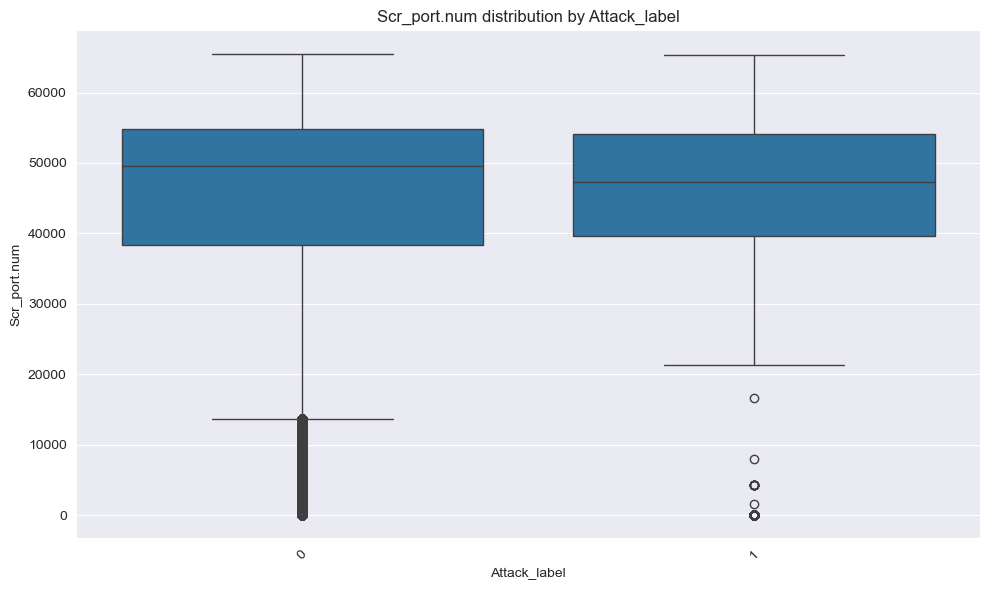

In [24]:
plot_target_relationship(
    df_clean,
    "Scr_port.num",
    log_scale=False,
)

In [25]:
df_clean.filter(pl.col("Attack_label") == 0)["Scr_port.num"].describe()

statistic,value
str,f64
"""count""",336599.0
"""null_count""",0.0
"""mean""",44811.077632
"""std""",14446.880102
"""min""",3.0
"""25%""",38360.0
"""50%""",49520.0
"""75%""",54797.0
"""max""",65535.0


In [26]:
df_clean.filter(pl.col("Attack_label") == 1)["Scr_port.num"].describe()

statistic,value
str,f64
"""count""",259418.0
"""null_count""",0.0
"""mean""",46973.453326
"""std""",8817.882249
"""min""",3.0
"""25%""",39702.0
"""50%""",47246.0
"""75%""",54095.0
"""max""",65268.0


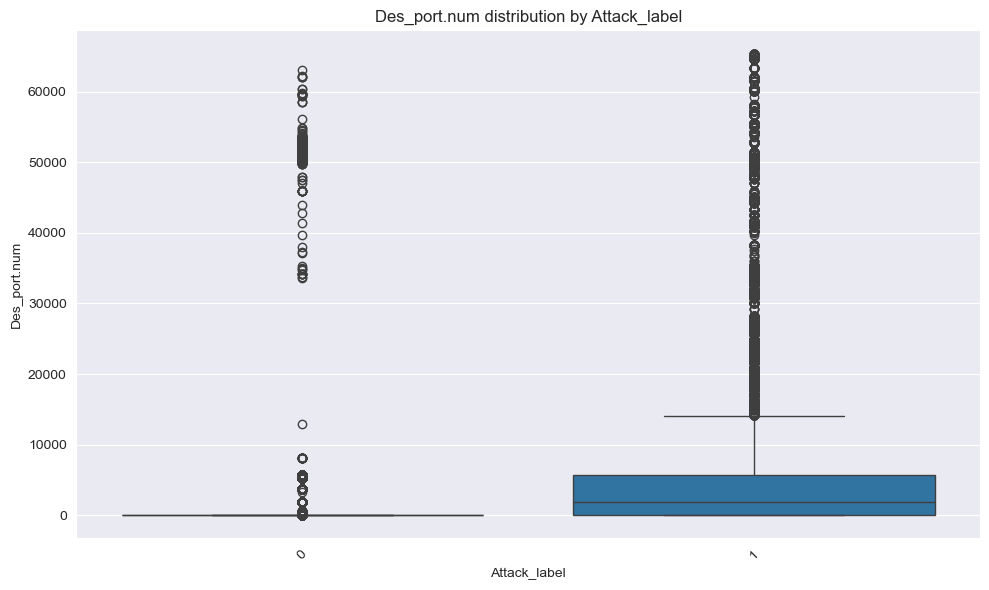

In [27]:
plot_target_relationship(
    df_clean,
    "Des_port.num",
    log_scale=False,
)

In [28]:
df_clean.filter(pl.col("Attack_label") == 0)["Des_port.num"].describe()

statistic,value
str,f64
"""count""",336599.0
"""null_count""",0.0
"""mean""",670.252969
"""std""",2314.7992
"""min""",0.0
"""25%""",53.0
"""50%""",80.0
"""75%""",80.0
"""max""",63029.0


In [29]:
df_clean.filter(pl.col("Attack_label") == 1)["Des_port.num"].describe()

statistic,value
str,f64
"""count""",259418.0
"""null_count""",0.0
"""mean""",3752.328497
"""std""",6299.697251
"""min""",0.0
"""25%""",80.0
"""50%""",1883.0
"""75%""",5683.0
"""max""",65389.0


VERDICT: Remove Scr_port but Keep Des_port

In [30]:
drop_string_columns("Scr_port", "Des_port")

ALL columns left: 22
STRING columns left: 8


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Des_IP""",820834,0,0.0,38.093,2.0,"""String""",96,"""Categorical - High Cardinality"""
"""Date""",820503,331,0.04,17.984,6.454,"""String""",50,"""Categorical - High Cardinality"""
"""Scr_IP""",820834,0,0.0,19.008,6.416,"""String""",36,"""Categorical - High Cardinality"""
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""


#### `Des_IP` and `Scr_IP`

In [31]:
df_clean["Des_IP"].head()

Des_IP
str
"""192.168.2.10"""
"""131.236.3.92"""
"""172.24.1.1"""
"""192.168.2.10"""
"""192.168.2.10"""
"""172.24.1.1"""
"""172.24.1.1"""
"""172.24.1.1"""
"""172.24.1.1"""


In [32]:
import socket
import struct
import ipaddress


def ip_to_int(ip):
    try:
        return struct.unpack("!I", socket.inet_aton(ip))[0]
    except (OSError, socket.error):
        return None


def int_to_ip(i):
    return socket.inet_ntoa(struct.pack("!I", i))


def get_shared_subnet_mask(ip1, ip2, default_value="null"):
    try:
        ipaddress.IPv4Address(ip1)
        ipaddress.IPv4Address(ip2)
    except ipaddress.AddressValueError:
        return default_value

    ip1_int = ip_to_int(ip1)
    ip2_int = ip_to_int(ip2)

    if ip1_int is None or ip2_int is None:
        return default_value

    xor = ip1_int ^ ip2_int
    if xor == 0:
        mask_len = 32
    else:
        mask_len = 32 - xor.bit_length()

    mask_int = (0xFFFFFFFF << (32 - mask_len)) & 0xFFFFFFFF
    return int_to_ip(mask_int)

In [33]:
df_clean = df_clean.with_columns(
    pl.col("Des_IP").map_elements(ip_to_int, return_dtype=pl.Int64).alias("Des_IP.num"),
    pl.col("Scr_IP").map_elements(ip_to_int, return_dtype=pl.Int64).alias("Scr_IP.num"),
)
df_clean.filter(pl.col("Des_IP").is_null() | pl.col("Scr_IP").is_null())

Date,Timestamp,Scr_IP,Scr_port,Des_IP,Des_port,Protocol,Service,Duration,Scr_bytes,Des_bytes,Conn_state,missed_bytes,is_syn_only,Is_SYN_ACK,is_pure_ack,is_with_payload,FIN or RST,Scr_pkts,Scr_ip_bytes,Des_pkts,Des_ip_bytes,anomaly_alert,total_bytes,total_packet,paket_rate,byte_rate,Scr_packts_ratio,Des_pkts_ratio,Scr_bytes_ratio,Des_bytes_ratio,Avg_user_time,Std_user_time,Avg_nice_time,Std_nice_time,Avg_system_time,Std_system_time,…,Des_ip_bytes.num,total_bytes.num,total_packet.num,paket_rate.num,byte_rate.num,Scr_packts_ratio.num,Des_pkts_ratio.num,Scr_bytes_ratio.num,Des_bytes_ratio.num,Avg_user_time.num,Std_user_time.num,Avg_nice_time.num,Std_nice_time.num,Avg_system_time.num,Std_system_time.num,Avg_iowait_time.num,Std_iowait_time.num,Avg_ideal_time.num,Std_ideal_time.num,Avg_tps.num,Std_tps.num,Avg_rtps.num,Std_rtps.num,Avg_wtps.num,Std_wtps.num,Avg_ldavg_1.num,Std_ldavg_1.num,Avg_kbmemused.num,Std_kbmemused.num,Avg_num_Proc/s.num,Std_num_proc/s.num,Avg_num_cswch/s.num,std_num_cswch/s.num,Scr_port.num,Des_port.num,Des_IP.num,Scr_IP.num
str,str,str,str,str,str,str,str,str,str,str,i64,str,bool,bool,bool,bool,bool,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64


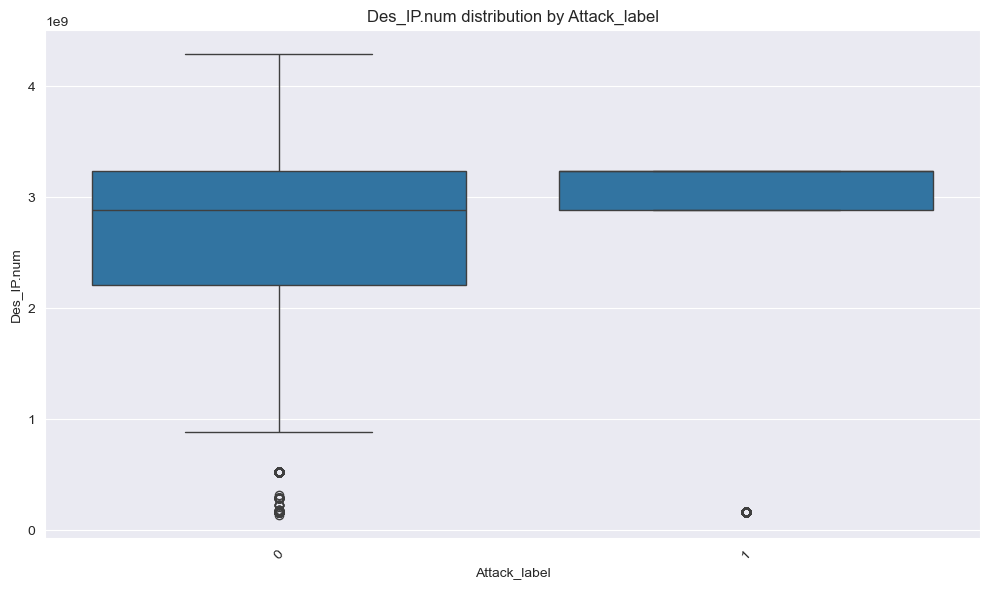

In [34]:
plot_target_relationship(
    df_clean,
    "Des_IP.num",
    log_scale=False,
)

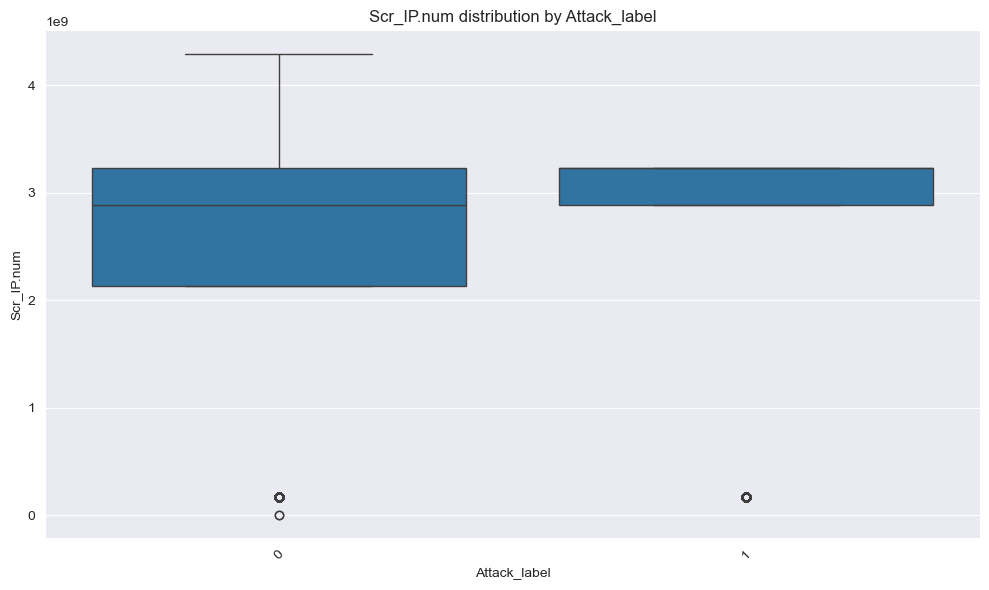

In [35]:
plot_target_relationship(
    df_clean,
    "Scr_IP.num",
    log_scale=False,
)

In [36]:
df_clean.filter(pl.col("Attack_label") == 0)["Des_IP.num"].describe()

statistic,value
str,f64
"""count""",336216.0
"""null_count""",383.0
"""mean""",2.8569e9
"""std""",4.5981e8
"""min""",1.34744072e8
"""25%""",2.2133e9
"""50%""",2.8873e9
"""75%""",3.2322e9
"""max""",4.2950e9


In [37]:
df_clean.filter(pl.col("Attack_label") == 1)["Des_IP.num"].describe()

statistic,value
str,f64
"""count""",259418.0
"""null_count""",0.0
"""mean""",3.0449e9
"""std""",4.2901e8
"""min""",1.67772421e8
"""25%""",2.8873e9
"""50%""",3.2322e9
"""75%""",3.2322e9
"""max""",3.2322e9


In [38]:
df_clean = df_clean.with_columns(
    pl.struct(["Des_IP", "Scr_IP"])
    .map_elements(lambda x: get_shared_subnet_mask(x["Des_IP"], x["Scr_IP"]), return_dtype=pl.Utf8)
    .alias("ip.subnet")
)

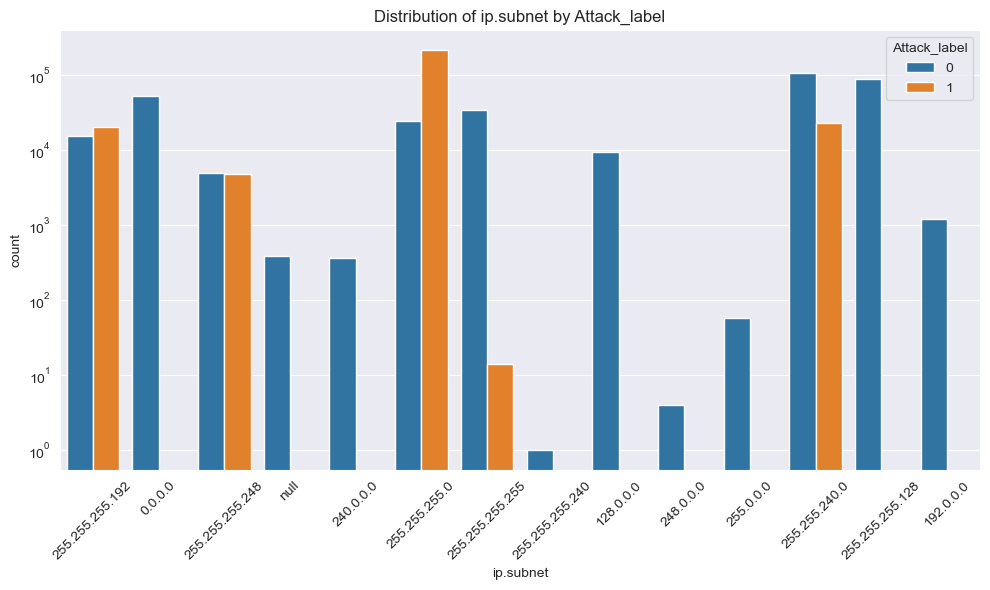

In [39]:
plot_target_relationship(df_clean, "ip.subnet", log_scale=True)

In [40]:
drop_string_columns("Scr_IP", "Des_IP")

ALL columns left: 20
STRING columns left: 6


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Date""",820503,331,0.04,17.984,6.454,"""String""",50,"""Categorical - High Cardinality"""
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""Protocol""",820834,0,0.0,51.452,3.255,"""String""",4,"""Categorical"""


In [41]:
columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""Date""",820503,331,0.04,17.984,6.454,"""String""",50,"""Categorical - High Cardinality"""
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""OSSEC_alert_level""",820834,0,0.0,94.881,90.205,"""Int64""",6,"""Categorical"""
…,…,…,…,…,…,…,…,…
"""Process_activity""",820834,0,0.0,91.738,83.476,"""Int64""",2,"""Flag"""
"""read_write_physical.process""",820834,0,0.0,64.469,28.938,"""Int64""",2,"""Flag"""
"""is_privileged""",820834,0,0.0,91.754,83.508,"""Int64""",2,"""Flag"""


#### `Date`

In [42]:
df_clean["Date"].head(n=5)

Date
str
"""9/01/2020"""
"""13/01/2020"""
"""9/01/2020"""
"""27/02/2020"""
"""31/01/2020"""


In [43]:
df_clean = df_clean.with_columns(
    pl.col("Date").str.strip_chars().str.strptime(pl.Date).alias("Date.num")
)
drop_string_columns("Date")

ALL columns left: 19
STRING columns left: 5


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""Service""",820834,0,0.0,28.963,1.83,"""String""",17,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""Protocol""",820834,0,0.0,51.452,3.255,"""String""",4,"""Categorical"""
"""class3""",820834,0,0.0,51.34,2.68,"""String""",2,"""Flag"""


#### `Service`: KEEP

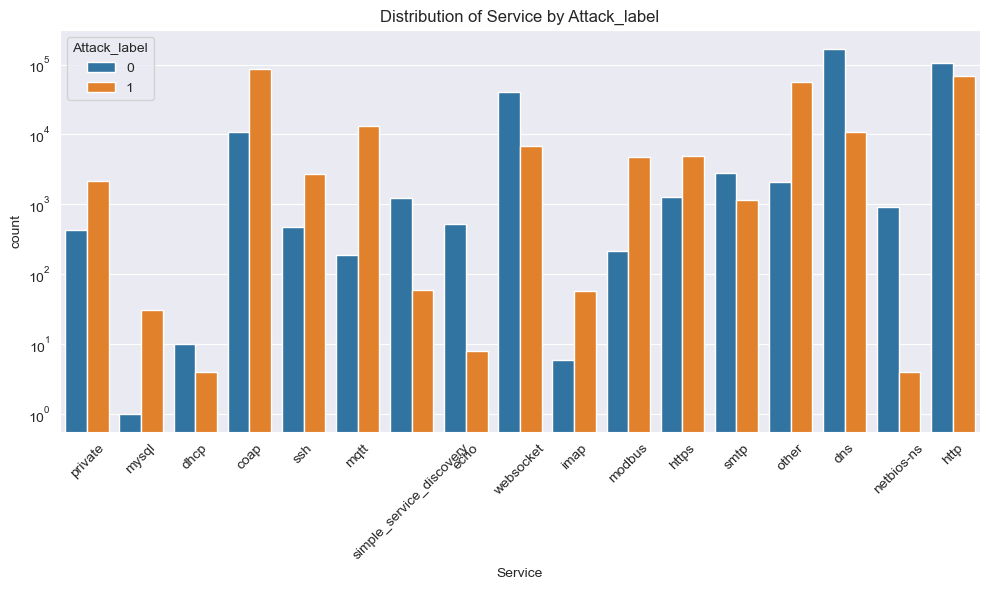

In [44]:
plot_target_relationship(df_clean, "Service", log_scale=True)

In [45]:
drop_string_columns("Service")

ALL columns left: 18
STRING columns left: 4


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""Protocol""",820834,0,0.0,51.452,3.255,"""String""",4,"""Categorical"""
"""class3""",820834,0,0.0,51.34,2.68,"""String""",2,"""Flag"""


#### `Protocol`: KEEP

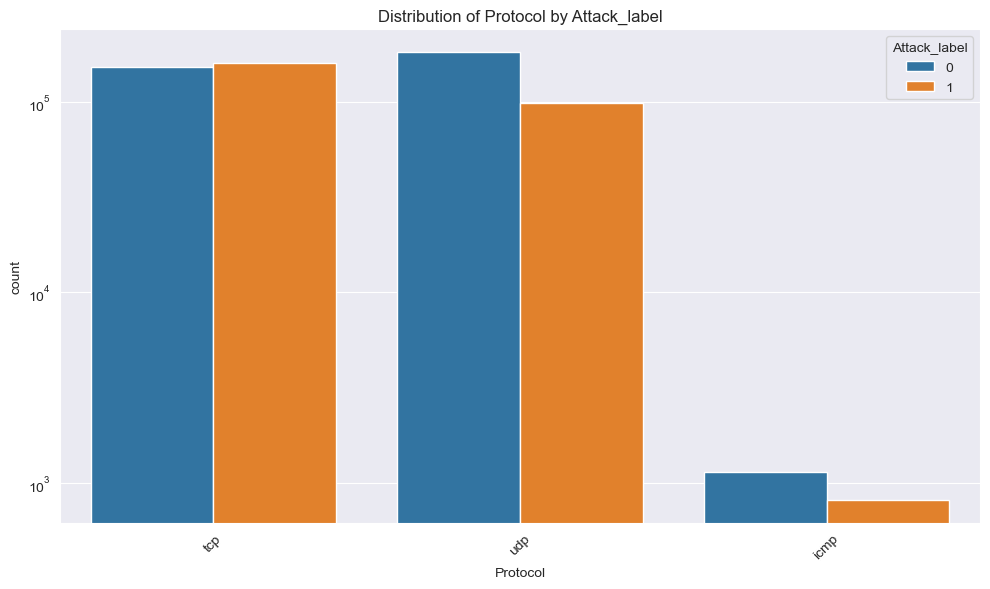

In [46]:
plot_target_relationship(df_clean, "Protocol", log_scale=True)

In [47]:
drop_string_columns("Protocol")

ALL columns left: 17
STRING columns left: 3


Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""class1""",820834,0,0.0,51.34,34.131,"""String""",19,"""Categorical - High Cardinality"""
"""class2""",820834,0,0.0,51.34,34.131,"""String""",10,"""Categorical"""
"""class3""",820834,0,0.0,51.34,2.68,"""String""",2,"""Flag"""


### Handle Categorical Columns

In [48]:
columns_df = columns_df.filter(~pl.col("Feature").is_in(["class1", "class2", "class3"]))
columns_df

Feature,Observations,Missing,Missing rate (%),1st value density (%),1st to 2nd value density difference (%),Variable type,Unique values,Feature type
str,i64,i64,f64,f64,f64,str,i64,str
"""OSSEC_alert_level""",820834,0,0.0,94.881,90.205,"""Int64""",6,"""Categorical"""
"""Conn_state""",820834,0,0.0,85.162,70.324,"""Int64""",2,"""Flag"""
"""is_with_payload""",820834,0,0.0,86.719,73.438,"""Boolean""",2,"""Flag"""
"""is_pure_ack""",820834,0,0.0,60.615,21.23,"""Boolean""",2,"""Flag"""
"""Is_SYN_ACK""",820834,0,0.0,60.646,21.292,"""Boolean""",2,"""Flag"""
…,…,…,…,…,…,…,…,…
"""File_activity""",820834,0,0.0,92.735,85.47,"""Int64""",2,"""Flag"""
"""Process_activity""",820834,0,0.0,91.738,83.476,"""Int64""",2,"""Flag"""
"""read_write_physical.process""",820834,0,0.0,64.469,28.938,"""Int64""",2,"""Flag"""


In [49]:
columns_df["Feature"].to_list()

['OSSEC_alert_level',
 'Conn_state',
 'is_with_payload',
 'is_pure_ack',
 'Is_SYN_ACK',
 'is_syn_only',
 'OSSEC_alert',
 'Login_attempt',
 'Succesful_login',
 'File_activity',
 'Process_activity',
 'read_write_physical.process',
 'is_privileged',
 'FIN or RST']